## **CNN - Problem set**



*  Take 10 photos of two different things and build your own CNN image classifier using the techniques we've built here.
* Optimize learning rate




Import Libraries 

In [1]:
#libraries for project 
import os
import random

# Get the class names (programmatically, this is much more helpful with a longer list of classes)
import pathlib
import numpy as np

# View an image and import data analysis tools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd

#import tensorflow image preprocessing `ImageDataGenerator` class
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Make the creating of our model a little easier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

Import Useful Functions 

In [2]:
def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

In [3]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  #loss metrics
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  #accuracy metrics
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure() #needs this call every time you want to create a new plot 
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [4]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=200):
  """
  Process of pre-processing random image to make predictions:

  1.Reads an image from filename
  2.Turns it into a tensor
  3.Reshapes it to (img_shape, img_shape, colour_channel)
  4.Normalizes data (divides RBG tensor info by 255)

  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [5]:
def pred_and_plot_binary(model, filename, class_names):
  """
  1.Imports an image located at filename 
  2.Makes a prediction on it with a trained model 
  3.Plots the image with the predicted class as the title
  
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = class_names[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

Import Data

Setup the training and test directory paths.

In [6]:
data_dir = "/content/drive/MyDrive/Colab Notebooks/ZTM - Deep Learning /Convolutional NN/problem_set/train"
dog_dir = "/content/drive/MyDrive/Colab Notebooks/ZTM - Deep Learning /Convolutional NN/problem_set/train/cat"
cat_dir = "/content/drive/MyDrive/Colab Notebooks/ZTM - Deep Learning /Convolutional NN/problem_set/train/dog"

In [7]:
import os
# Walk through pizza_steak directory and list number of files
for dirpath, dirnames, filenames in os.walk("/content/drive/MyDrive/Colab Notebooks/ZTM - Deep Learning /Convolutional NN/problem_set"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 2 images in '/content/drive/MyDrive/Colab Notebooks/ZTM - Deep Learning /Convolutional NN/problem_set'.
There are 2 directories and 0 images in '/content/drive/MyDrive/Colab Notebooks/ZTM - Deep Learning /Convolutional NN/problem_set/train'.
There are 0 directories and 15 images in '/content/drive/MyDrive/Colab Notebooks/ZTM - Deep Learning /Convolutional NN/problem_set/train/cat'.
There are 0 directories and 16 images in '/content/drive/MyDrive/Colab Notebooks/ZTM - Deep Learning /Convolutional NN/problem_set/train/dog'.
There are 2 directories and 0 images in '/content/drive/MyDrive/Colab Notebooks/ZTM - Deep Learning /Convolutional NN/problem_set/test'.
There are 0 directories and 4 images in '/content/drive/MyDrive/Colab Notebooks/ZTM - Deep Learning /Convolutional NN/problem_set/test/dog'.
There are 0 directories and 4 images in '/content/drive/MyDrive/Colab Notebooks/ZTM - Deep Learning /Convolutional NN/problem_set/test/cat'.


In [8]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)
import pathlib
import numpy as np
data_dir = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/ZTM - Deep Learning /Convolutional NN/problem_set/train") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['cat' 'dog']


In [51]:
# Using ImageDataGenerators to read in images with labels 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Creating a instance of the ImageDataGenerator 
train_datagen = ImageDataGenerator(rescale = 1/255., 
                                   validation_split = 0.3) # creating a valid split in the train data
valid_datagen = ImageDataGenerator(rescale=1/255.)

# Grabbing our image file from directories 
train_data = train_datagen.flow_from_directory(data_dir , 
                                               batch_size = 2 , 
                                               target_size = (200 , 200), 
                                               class_mode = 'binary', 
                                               seed = 42 , 
                                               subset = 'training')

valid_data = train_datagen.flow_from_directory(data_dir , 
                                               batch_size = 2 , 
                                               target_size = (200 , 200) , 
                                               class_mode = 'binary' , 
                                               seed = 42 , 
                                               subset = 'validation')

Found 23 images belonging to 2 classes.
Found 8 images belonging to 2 classes.


In [10]:
# Check lengths of training and test data generators
len(train_data), len(valid_data)

(12, 4)

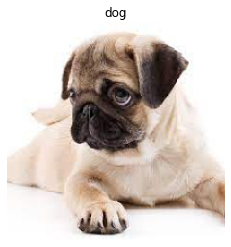

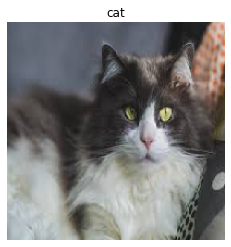

In [11]:
# Let's do a simple visualization (checking purpose)
x , y  = train_data.next()
for i in range(2):
  image = x[i]
  label = y[i]
  plt.axis(False)
  # print(label) --> for checking whether it's plotting right ones
  if label == 1.0:
    label = 'dog'
  else:
    label = 'cat'
  plt.title(label)
  plt.imshow(image)
  plt.show()

In [12]:
x.shape

(2, 200, 200, 3)

In [13]:
# Set random seed
tf.random.set_seed(42)

# Create the model (this can be our baseline, a 3 layer Convolutional Neural Network)
model_1 = Sequential([
  Conv2D(filters=15, 
         kernel_size=3, 
         strides=1,
         padding='valid',
         activation='relu', 
         input_shape=(200, 200, 3)), # input layer (specify input shape)
  MaxPool2D(1 , padding= 'valid'),
  Conv2D(15, 3, activation='relu'),
  MaxPool2D(1 , padding= 'valid'),
  Flatten(),
  Dense(1, activation='sigmoid') # output layer (specify output shape)
])

# Compile the model
model_1.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=10,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/10
12/12 [==============================] - 35s 2s/step - loss: 10.4548 - accuracy: 0.5217 - val_loss: 4.9237 - val_accuracy: 0.5000
Epoch 2/10
12/12 [==============================] - 0s 17ms/step - loss: 0.7759 - accuracy: 0.6522 - val_loss: 0.6151 - val_accuracy: 0.3750
Epoch 3/10
12/12 [==============================] - 0s 16ms/step - loss: 0.4400 - accuracy: 0.8696 - val_loss: 0.5978 - val_accuracy: 0.6250
Epoch 4/10
12/12 [==============================] - 0s 15ms/step - loss: 0.1569 - accuracy: 0.9565 - val_loss: 0.5160 - val_accuracy: 0.8750
Epoch 5/10
12/12 [==============================] - 0s 14ms/step - loss: 0.1197 - accuracy: 0.9565 - val_loss: 0.5534 - val_accuracy: 0.7500
Epoch 6/10
12/12 [==============================] - 0s 16ms/step - loss: 0.0498 - accuracy: 1.0000 - val_loss: 0.3850 - val_accuracy: 0.7500
Epoch 7/10
12/12 [==============================] - 0s 17ms/step - loss: 0.0223 - accuracy: 1.0000 - val_loss: 0.3932 - val_accuracy: 0.8750
Epoch 8/10
12

(None,)

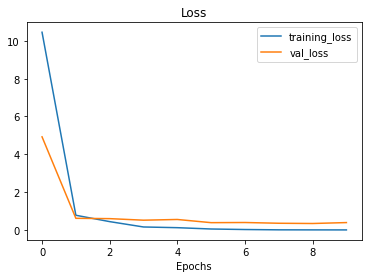

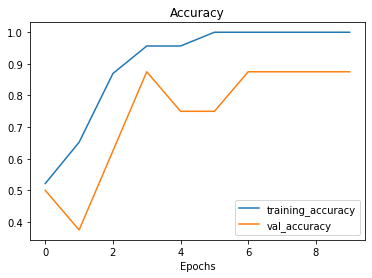

In [14]:
# Check model's performance history training on augmented data
plot_loss_curves(history_1), 

Make a Prediction

1. Cat Picture

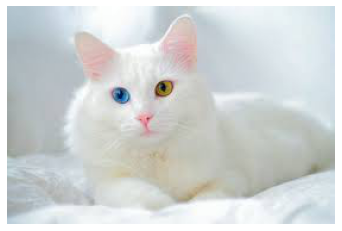

In [15]:
# View example image
cat = mpimg.imread("/content/drive/MyDrive/Colab Notebooks/ZTM - Deep Learning /Convolutional NN/problem_set/cat.jpg")
plt.imshow(cat)
plt.axis(False);

In [16]:
cat.shape

(183, 276, 3)

In [17]:
# Load in and preprocess our custom image
cat = load_and_prep_image("/content/drive/MyDrive/Colab Notebooks/ZTM - Deep Learning /Convolutional NN/problem_set/cat.jpg")
cat

<tf.Tensor: shape=(200, 200, 3), dtype=float32, numpy=
array([[[0.69803923, 0.77254903, 0.8       ],
        [0.69803923, 0.77254903, 0.8       ],
        [0.7017647 , 0.7762745 , 0.8037255 ],
        ...,
        [0.7921569 , 0.8666667 , 0.89411765],
        [0.7921569 , 0.8666667 , 0.89411765],
        [0.7889804 , 0.8634902 , 0.8909412 ]],

       [[0.69803923, 0.77254903, 0.8       ],
        [0.69803923, 0.77254903, 0.8       ],
        [0.6985142 , 0.773024  , 0.800475  ],
        ...,
        [0.7921569 , 0.8666667 , 0.89411765],
        [0.7921569 , 0.8666667 , 0.89411765],
        [0.79175186, 0.86626166, 0.89371264]],

       [[0.69495094, 0.76946074, 0.7969117 ],
        [0.6967113 , 0.7712211 , 0.7986721 ],
        [0.69803923, 0.77254903, 0.8       ],
        ...,
        [0.7952451 , 0.8697549 , 0.8972059 ],
        [0.7939172 , 0.868427  , 0.89587796],
        [0.7921569 , 0.8666667 , 0.89411765]],

       ...,

       [[0.72540194, 0.8038333 , 0.84697056],
        [0.73

In [18]:
cat_dir = "/content/drive/MyDrive/Colab Notebooks/ZTM - Deep Learning /Convolutional NN/problem_set/cat.jpg"

In [19]:
# Add an extra axis
print(f"Shape before new dimension: {cat.shape}")
cat = tf.expand_dims(cat, axis=0) # add an extra dimension at axis 0
#steak = steak[tf.newaxis, ...] # alternative to the above, '...' is short for 'every other dimension'
print(f"Shape after new dimension: {cat.shape}")
cat

Shape before new dimension: (200, 200, 3)
Shape after new dimension: (1, 200, 200, 3)


<tf.Tensor: shape=(1, 200, 200, 3), dtype=float32, numpy=
array([[[[0.69803923, 0.77254903, 0.8       ],
         [0.69803923, 0.77254903, 0.8       ],
         [0.7017647 , 0.7762745 , 0.8037255 ],
         ...,
         [0.7921569 , 0.8666667 , 0.89411765],
         [0.7921569 , 0.8666667 , 0.89411765],
         [0.7889804 , 0.8634902 , 0.8909412 ]],

        [[0.69803923, 0.77254903, 0.8       ],
         [0.69803923, 0.77254903, 0.8       ],
         [0.6985142 , 0.773024  , 0.800475  ],
         ...,
         [0.7921569 , 0.8666667 , 0.89411765],
         [0.7921569 , 0.8666667 , 0.89411765],
         [0.79175186, 0.86626166, 0.89371264]],

        [[0.69495094, 0.76946074, 0.7969117 ],
         [0.6967113 , 0.7712211 , 0.7986721 ],
         [0.69803923, 0.77254903, 0.8       ],
         ...,
         [0.7952451 , 0.8697549 , 0.8972059 ],
         [0.7939172 , 0.868427  , 0.89587796],
         [0.7921569 , 0.8666667 , 0.89411765]],

        ...,

        [[0.72540194, 0.8038333 , 

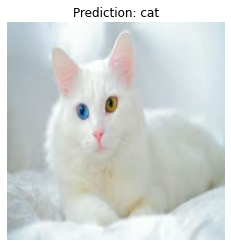

In [20]:
# Test our model on a custom image
pred_and_plot_binary(model_1, cat_dir, class_names)

2. Predict dog

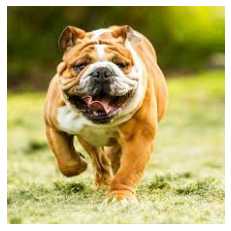

In [21]:
# View example image
dog = mpimg.imread("/content/drive/MyDrive/Colab Notebooks/ZTM - Deep Learning /Convolutional NN/problem_set/dog.jpg")
plt.imshow(dog)
plt.axis(False);

In [22]:
# Load in and preprocess our custom image
dog = load_and_prep_image("/content/drive/MyDrive/Colab Notebooks/ZTM - Deep Learning /Convolutional NN/problem_set/dog.jpg")
dog

<tf.Tensor: shape=(200, 200, 3), dtype=float32, numpy=
array([[[0.32155332, 0.31371018, 0.12155331],
        [0.325     , 0.31715685, 0.12352941],
        [0.3261489 , 0.31830576, 0.11830576],
        ...,
        [0.89664525, 0.8888021 , 0.42164522],
        [0.89799327, 0.887163  , 0.42637867],
        [0.9014859 , 0.8970895 , 0.4414522 ]],

       [[0.3154412 , 0.30759802, 0.11544117],
        [0.3154412 , 0.30759802, 0.11424632],
        [0.3154412 , 0.30759802, 0.10906862],
        ...,
        [0.89287686, 0.88678   , 0.40785846],
        [0.8958333 , 0.88959867, 0.41764706],
        [0.897258  , 0.89387256, 0.42789522]],

       [[0.30343136, 0.29558823, 0.10343137],
        [0.3032016 , 0.29535845, 0.10320159],
        [0.3022059 , 0.29436275, 0.10220588],
        ...,
        [0.88589156, 0.8877451 , 0.38526347],
        [0.8872396 , 0.8889706 , 0.39581802],
        [0.89257044, 0.8926471 , 0.4111213 ]],

       ...,

       [[0.92068017, 0.8871017 , 0.6121783 ],
        [0.86

In [23]:
# Add an extra axis
print(f"Shape before new dimension: {dog.shape}")
dog = tf.expand_dims(dog, axis=0) # add an extra dimension at axis 0
#steak = steak[tf.newaxis, ...] # alternative to the above, '...' is short for 'every other dimension'
print(f"Shape after new dimension: {dog.shape}")
dog

Shape before new dimension: (200, 200, 3)
Shape after new dimension: (1, 200, 200, 3)


<tf.Tensor: shape=(1, 200, 200, 3), dtype=float32, numpy=
array([[[[0.32155332, 0.31371018, 0.12155331],
         [0.325     , 0.31715685, 0.12352941],
         [0.3261489 , 0.31830576, 0.11830576],
         ...,
         [0.89664525, 0.8888021 , 0.42164522],
         [0.89799327, 0.887163  , 0.42637867],
         [0.9014859 , 0.8970895 , 0.4414522 ]],

        [[0.3154412 , 0.30759802, 0.11544117],
         [0.3154412 , 0.30759802, 0.11424632],
         [0.3154412 , 0.30759802, 0.10906862],
         ...,
         [0.89287686, 0.88678   , 0.40785846],
         [0.8958333 , 0.88959867, 0.41764706],
         [0.897258  , 0.89387256, 0.42789522]],

        [[0.30343136, 0.29558823, 0.10343137],
         [0.3032016 , 0.29535845, 0.10320159],
         [0.3022059 , 0.29436275, 0.10220588],
         ...,
         [0.88589156, 0.8877451 , 0.38526347],
         [0.8872396 , 0.8889706 , 0.39581802],
         [0.89257044, 0.8926471 , 0.4111213 ]],

        ...,

        [[0.92068017, 0.8871017 , 

In [24]:
dog_dir = "/content/drive/MyDrive/Colab Notebooks/ZTM - Deep Learning /Convolutional NN/problem_set/dog.jpg"

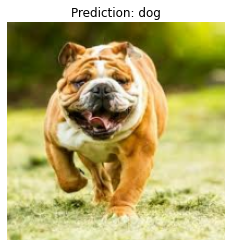

In [25]:
# Test our model on a custom image
pred_and_plot_binary(model_1, dog_dir, class_names)

In [26]:
# Make a prediction on custom image tensor
pred = model_1.predict(dog)
pred

array([[0.8064522]], dtype=float32)

In [27]:
# We can index the predicted class by rounding the prediction probability
pred_class = class_names[int(tf.round(pred)[0][0])]
pred_class

'dog'

Optimize Learning Rate


In [28]:
# Lets import learning rate scheduler 
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))

In [29]:
# Fit the model with lr scheduler
lr_history = model_1.fit(train_data, 
                         epochs = 10, 
                         validation_data = valid_data, 
                         callbacks = [lr_scheduler])

Epoch 1/10
12/12 [==============================] - 0s 19ms/step - loss: 9.0819e-04 - accuracy: 1.0000 - val_loss: 0.3942 - val_accuracy: 0.8750 - lr: 1.0000e-04
Epoch 2/10
12/12 [==============================] - 0s 15ms/step - loss: 8.7985e-04 - accuracy: 1.0000 - val_loss: 0.3989 - val_accuracy: 0.8750 - lr: 1.1220e-04
Epoch 3/10
12/12 [==============================] - 0s 16ms/step - loss: 8.4792e-04 - accuracy: 1.0000 - val_loss: 0.4011 - val_accuracy: 0.8750 - lr: 1.2589e-04
Epoch 4/10
12/12 [==============================] - 0s 17ms/step - loss: 8.1957e-04 - accuracy: 1.0000 - val_loss: 0.3996 - val_accuracy: 0.8750 - lr: 1.4125e-04
Epoch 5/10
12/12 [==============================] - 0s 16ms/step - loss: 7.8023e-04 - accuracy: 1.0000 - val_loss: 0.4016 - val_accuracy: 0.8750 - lr: 1.5849e-04
Epoch 6/10
12/12 [==============================] - 0s 18ms/step - loss: 7.4185e-04 - accuracy: 1.0000 - val_loss: 0.4069 - val_accuracy: 0.8750 - lr: 1.7783e-04
Epoch 7/10
12/12 [==========

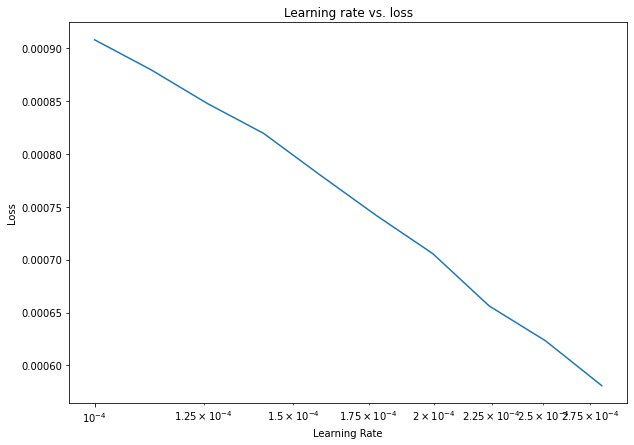

In [30]:
# Plot the learning rate versus the loss (to figure out where is the inflection point)
lrs = 1e-4 * (10 ** (np.arange(10)/20))
plt.figure(figsize=(10, 7))
plt.semilogx(lrs, lr_history.history["loss"]) # we want the x-axis (learning rate) to be log scale
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning rate vs. loss");

In [31]:
# Our learning rate from the graph above 
lr = 2.8 * 1e-4
lr

0.00028

In [32]:
# Set random seed
tf.random.set_seed(42)

# Create the model (this can be our baseline, a 3 layer Convolutional Neural Network)
model_2 = Sequential([
  Conv2D(filters=15, 
         kernel_size=3, 
         strides=1,
         padding='valid',
         activation='relu', 
         input_shape=(200, 200, 3)), # input layer (specify input shape)
  MaxPool2D(1 , padding= 'valid'),
  Conv2D(15, 3, activation='relu'),
  MaxPool2D(1 , padding= 'valid'),
  Flatten(),
  Dense(1, activation='sigmoid') # output layer (specify output shape)
])

# Compile the model
model_2.compile(loss='binary_crossentropy',
                optimizer=Adam(learning_rate=lr),
                metrics=['accuracy'])

# Fit the model 
history_2 = model_2.fit(train_data , 
                        epochs = 10 , 
                        validation_data = valid_data)

Epoch 1/10
12/12 [==============================] - 1s 27ms/step - loss: 1.3189 - accuracy: 0.5652 - val_loss: 0.5527 - val_accuracy: 0.7500
Epoch 2/10
12/12 [==============================] - 0s 17ms/step - loss: 0.3554 - accuracy: 0.8696 - val_loss: 0.5465 - val_accuracy: 0.8750
Epoch 3/10
12/12 [==============================] - 0s 16ms/step - loss: 0.0688 - accuracy: 1.0000 - val_loss: 0.7980 - val_accuracy: 0.7500
Epoch 4/10
12/12 [==============================] - 0s 17ms/step - loss: 0.3236 - accuracy: 0.8261 - val_loss: 0.6662 - val_accuracy: 0.6250
Epoch 5/10
12/12 [==============================] - 0s 17ms/step - loss: 0.1241 - accuracy: 0.9565 - val_loss: 0.8585 - val_accuracy: 0.5000
Epoch 6/10
12/12 [==============================] - 0s 17ms/step - loss: 0.2227 - accuracy: 0.9565 - val_loss: 2.0952 - val_accuracy: 0.6250
Epoch 7/10
12/12 [==============================] - 0s 17ms/step - loss: 0.0204 - accuracy: 1.0000 - val_loss: 1.0166 - val_accuracy: 0.7500
Epoch 8/10
12

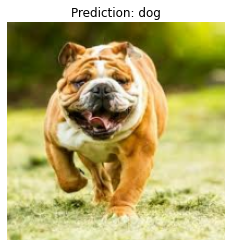

In [33]:
# Test our model on a custom image
pred_and_plot_binary(model_2, dog_dir, class_names)

In [34]:
# Make a prediction on custom image tensor
pred_2 = model_2.predict(dog)
pred_2

array([[0.99913484]], dtype=float32)

In [36]:
# We can index the predicted class by rounding the prediction probability
pred_class_2 = class_names[int(tf.round(pred_2)[0][0])]
pred_class_2

'dog'

## **Use Reinforcement Learning**

We'll look at:

* EfficientNet - a state of the art computer vision architecture from 2019.



In [42]:
#import libraries
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

#define parameters for future use in functions
IMAGE_SHAPE = (200, 200)
BATCH_SIZE = 32

In [43]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [71]:
# New: EfficientNetB0 feature vector (version 2)
efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

In [69]:
#create function to import model (binary classificaiton version)
def create_model_binary(model_url, num_classes):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='sigmoid', name='output_layer') # create our own output layer      
  ])

  return model

In [61]:
# Visualize model performance 
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):

  """
  Returns separate loss curves for training and validation metrics.

    Args:
      History: Tensorflow history object

    Returns:
      Plots of training/validation loss and accuracy metrics
  
  Note: function will only work with accuracy, will need to adjust
        if using another metric. 

  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss Plot')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy Plot')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend();

In [73]:
# Create model
efficientnet_model = create_model_binary(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                         num_classes=1)
# Compile EfficientNet model
efficientnet_model.compile(loss='binary_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnet_history = efficientnet_model.fit(train_data,
                                              epochs=10,
                                              steps_per_epoch=len(train_data),
                                              validation_data=valid_data,
                                              validation_steps=len(valid_data))

Epoch 1/10
12/12 [==============================] - 8s 98ms/step - loss: 0.7126 - accuracy: 0.5652 - val_loss: 0.5621 - val_accuracy: 0.7500
Epoch 2/10
12/12 [==============================] - 0s 28ms/step - loss: 0.5070 - accuracy: 0.8261 - val_loss: 0.4710 - val_accuracy: 0.7500
Epoch 3/10
12/12 [==============================] - 0s 27ms/step - loss: 0.3773 - accuracy: 0.9130 - val_loss: 0.4173 - val_accuracy: 0.7500
Epoch 4/10
12/12 [==============================] - 0s 26ms/step - loss: 0.2835 - accuracy: 1.0000 - val_loss: 0.3713 - val_accuracy: 0.8750
Epoch 5/10
12/12 [==============================] - 0s 24ms/step - loss: 0.2240 - accuracy: 1.0000 - val_loss: 0.3323 - val_accuracy: 0.8750
Epoch 6/10
12/12 [==============================] - 0s 31ms/step - loss: 0.1807 - accuracy: 1.0000 - val_loss: 0.3045 - val_accuracy: 1.0000
Epoch 7/10
12/12 [==============================] - 0s 25ms/step - loss: 0.1492 - accuracy: 1.0000 - val_loss: 0.2848 - val_accuracy: 1.0000
Epoch 8/10
12

Predict different cat picture 

In [78]:
cat_2_dir = "/content/drive/MyDrive/Colab Notebooks/ZTM - Deep Learning /Convolutional NN/problem_set/cat_2.jpg"

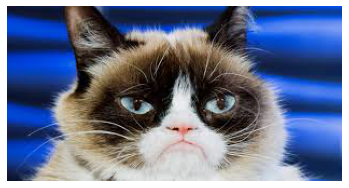

In [79]:
# View example image
cat_2 = mpimg.imread(cat_2_dir)
plt.imshow(cat_2)
plt.axis(False);

In [80]:
# Load in and preprocess our custom image
cat_2 = load_and_prep_image(cat_2_dir)
cat_2

<tf.Tensor: shape=(200, 200, 3), dtype=float32, numpy=
array([[[0.09411765, 0.06666667, 0.2       ],
        [0.09085294, 0.06666667, 0.2       ],
        [0.0847549 , 0.06906863, 0.19848038],
        ...,
        [0.        , 0.3137255 , 0.8980392 ],
        [0.        , 0.3137255 , 0.8980392 ],
        [0.        , 0.3137255 , 0.8980392 ]],

       [[0.08850981, 0.06464083, 0.19641799],
        [0.0852451 , 0.06666667, 0.19672643],
        [0.07806054, 0.06735122, 0.19115515],
        ...,
        [0.00108655, 0.30422717, 0.8665652 ],
        [0.00233432, 0.3029794 , 0.8690608 ],
        [0.00202584, 0.3032879 , 0.86844385]],

       [[0.07746789, 0.06532083, 0.18972991],
        [0.07442966, 0.06495269, 0.18890025],
        [0.06795466, 0.06586887, 0.18126102],
        ...,
        [0.0056373 , 0.290147  , 0.81078446],
        [0.00738243, 0.28840187, 0.81427467],
        [0.00695099, 0.28883332, 0.81341183]],

       ...,

       [[0.02873525, 0.07167647, 0.17197052],
        [0.03

In [81]:
# Add an extra axis
print(f"Shape before new dimension: {cat_2.shape}")
cat_2 = tf.expand_dims(cat_2, axis=0) # add an extra dimension at axis 0
#steak = steak[tf.newaxis, ...] # alternative to the above, '...' is short for 'every other dimension'
print(f"Shape after new dimension: {cat_2.shape}")
cat_2

Shape before new dimension: (200, 200, 3)
Shape after new dimension: (1, 200, 200, 3)


<tf.Tensor: shape=(1, 200, 200, 3), dtype=float32, numpy=
array([[[[0.09411765, 0.06666667, 0.2       ],
         [0.09085294, 0.06666667, 0.2       ],
         [0.0847549 , 0.06906863, 0.19848038],
         ...,
         [0.        , 0.3137255 , 0.8980392 ],
         [0.        , 0.3137255 , 0.8980392 ],
         [0.        , 0.3137255 , 0.8980392 ]],

        [[0.08850981, 0.06464083, 0.19641799],
         [0.0852451 , 0.06666667, 0.19672643],
         [0.07806054, 0.06735122, 0.19115515],
         ...,
         [0.00108655, 0.30422717, 0.8665652 ],
         [0.00233432, 0.3029794 , 0.8690608 ],
         [0.00202584, 0.3032879 , 0.86844385]],

        [[0.07746789, 0.06532083, 0.18972991],
         [0.07442966, 0.06495269, 0.18890025],
         [0.06795466, 0.06586887, 0.18126102],
         ...,
         [0.0056373 , 0.290147  , 0.81078446],
         [0.00738243, 0.28840187, 0.81427467],
         [0.00695099, 0.28883332, 0.81341183]],

        ...,

        [[0.02873525, 0.07167647, 

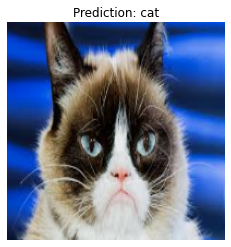

In [82]:
# Test our model on a custom image
pred_and_plot_binary(efficientnet_model, cat_2_dir, class_names)

In [86]:
# Make a prediction on custom image tensor
pred_cat_2 = efficientnet_model.predict(cat_2)
pred_cat_2

array([[0.01636874]], dtype=float32)

In [87]:
# We can index the predicted class by rounding the prediction probability
pred_class = class_names[int(tf.round(pred_cat_2)[0][0])]
pred_class

'cat'